In [13]:
from robustbench.data import load_cifar10
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import torchattacks

In [14]:
# Simple CNN Model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        # First conv block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)  # 32x32 -> 16x16
        
        # Second conv block
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(2, 2)  # 16x16 -> 8x8
        
        # Third conv block
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(2, 2)  # 8x8 -> 4x4
        
        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.relu = nn.ReLU()

    def forward(self, x, gradient_routing = False, return_routed_act=False):
        # First conv block
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.pool1(x)
        
        # Second conv block
        x = self.relu(self.conv3(x))
        x = self.relu(self.conv4(x))
        x = self.pool2(x)
        
        # Third conv block
        x = self.relu(self.conv5(x))
        x = self.pool3(x)
        
        # Flatten and fully connected
        act = x.view(x.size(0), -1)
        halfway_point = x.shape[1] // 2
        # print(halfway_point)

        if gradient_routing:
            mask = torch.zeros_like(act)
            mask[:, :halfway_point, ...] = 1 # half of values become 1
            x = mask * act + (1 - mask) * act.detach() # from https://arxiv.org/pdf/2410.04332
        else:
            x = act

        routed_activation = x.clone().detach()
        
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
            
        if return_routed_act:
            return x, routed_activation
        return x

# Data loading and preprocessing
def load_cifar10():
    # Simple data augmentation for training
    train_transform = transforms.Compose([
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomCrop(32, padding=4),
        transforms.ToTensor(),
    ])
    
    # No augmentation for test
    test_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    # Load datasets
    trainset = torchvision.datasets.CIFAR10(
        root='./data', train=True, download=True, transform=train_transform
    )
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=128, shuffle=True, num_workers=2
    )
    
    testset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=test_transform
    )
    testloader = torch.utils.data.DataLoader(
        testset, batch_size=128, shuffle=False, num_workers=2
    )
    return trainloader, testloader

In [15]:
trainloader, testloader = load_cifar10()

In [16]:
model = SimpleCNN(num_classes=10)
print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

Model parameters: 2,638,794


In [17]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=100)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1.5, kappa=0, steps=200)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)


def get_targeted_attack_imgs(clean_imgs, clean_labels):
    # get random labels for targeted attack!
    adv_targets = torch.randint(0, 9, clean_labels.shape, device=device)
    adv_targets = torch.where(adv_targets >= clean_labels, adv_targets + 1, adv_targets)

    # print(clean_imgs.shape)
    adv_images = pgd(clean_imgs, adv_targets)
    
    with torch.no_grad():
        outputs = model(adv_images.to(device))
        _, predicted = torch.max(outputs, 1)
    
    success_rate = (predicted == adv_targets).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')

    succ_adv_imgs = adv_images[predicted == adv_targets]
    adv_targets = adv_targets[predicted == adv_targets]
    print(f'{len(succ_adv_imgs)} successful adversarial imgs')
    return succ_adv_imgs, adv_targets

# Training function
def train_model(model, trainloader, num_epochs=10):
    device = 'mps'
    model.to(device)
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    train_accuracies = []
    
    print(f"Training on {device}")
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (inputs, targets) in enumerate(trainloader):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            
            if batch_idx % 10 == 0:
                print("adv forward")
                inputs, targets = get_targeted_attack_imgs(inputs, targets)
                out, act = model(inputs, gradient_routing=True, return_routed_act=True)
            else:
                print("regular forward")
                out, act = model(inputs, return_routed_act=True)

            # mask = torch.zeros_like(routed_act_dirty)
            # mask[:, :64, ...] = 1
            
            print("pixel norm", torch.sum(torch.abs(act[:, :128, ...])).item())
            print("human norm", torch.sum(torch.abs(act[:, 128:, ...])).item())

            loss = criterion(out, targets)
            loss.backward()
            optimizer.step()

            if batch_idx % 10 != 0:
                running_loss += loss.item()
                _, predicted = out.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()
            
            if batch_idx % 100 == 99:
                print(f'Epoch: {epoch+1}/{num_epochs}, Batch: {batch_idx}, '
                      f'Loss: {loss.item():.4f}, Acc: {100.*correct/total:.2f}%')
        
        epoch_loss = running_loss / len(trainloader)
        epoch_acc = 100. * correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)
        
        print(f'Epoch {epoch+1} completed: Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')
    
    return train_losses, train_accuracies

In [18]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=10)


Starting training...
Training on mps
adv forward
Attack success rate: 7.81%
10 successful adversarial imgs
pixel norm 12.563365936279297
human norm 426.40545654296875
regular forward
pixel norm 450.77703857421875
human norm 6559.103515625
regular forward
pixel norm 897.2289428710938
human norm 11842.8984375
regular forward
pixel norm 520.86474609375
human norm 5323.9462890625
regular forward
pixel norm 294.1448974609375
human norm 2657.21875
regular forward
pixel norm 211.95709228515625
human norm 1703.895751953125
regular forward
pixel norm 171.6010284423828
human norm 1306.2705078125
regular forward
pixel norm 175.54745483398438
human norm 1148.63720703125
regular forward
pixel norm 203.52178955078125
human norm 1341.606689453125
regular forward
pixel norm 213.3427734375
human norm 1629.159912109375
adv forward
Attack success rate: 7.03%
9 successful adversarial imgs
pixel norm 15.817450523376465
human norm 137.33889770507812
regular forward
pixel norm 325.02484130859375
human norm 

python(28454) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(28455) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


adv forward
Attack success rate: 95.31%
122 successful adversarial imgs
pixel norm 3079.05322265625
human norm 3805.90478515625
regular forward
pixel norm 2947.05126953125
human norm 3409.174560546875
regular forward
pixel norm 2925.572509765625
human norm 3389.11962890625
regular forward
pixel norm 3067.12646484375
human norm 3369.28271484375
regular forward
pixel norm 2863.78466796875
human norm 3363.32666015625
regular forward
pixel norm 2700.8095703125
human norm 3450.046875
regular forward
pixel norm 2596.990234375
human norm 3359.820556640625
regular forward
pixel norm 2577.78369140625
human norm 3525.565673828125
regular forward
pixel norm 2484.6611328125
human norm 3743.02294921875
regular forward
pixel norm 2529.927978515625
human norm 3685.7666015625
adv forward
Attack success rate: 99.22%
127 successful adversarial imgs
pixel norm 3026.93798828125
human norm 4158.8017578125
regular forward
pixel norm 2619.96044921875
human norm 3524.89306640625
regular forward
pixel norm 278

python(28477) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(28478) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


adv forward
Attack success rate: 97.66%
125 successful adversarial imgs
pixel norm 2584.107177734375
human norm 4628.865234375
regular forward
pixel norm 2118.842529296875
human norm 4106.46484375
regular forward
pixel norm 2324.77587890625
human norm 3939.396484375
regular forward
pixel norm 2296.324462890625
human norm 3983.038818359375
regular forward
pixel norm 2380.2578125
human norm 3782.41943359375
regular forward
pixel norm 2412.153564453125
human norm 3701.3828125
regular forward
pixel norm 2436.10595703125
human norm 3970.744140625
regular forward
pixel norm 2471.46044921875
human norm 3842.45751953125
regular forward
pixel norm 2301.640869140625
human norm 4076.6728515625
regular forward
pixel norm 2279.32861328125
human norm 4144.85009765625
adv forward
Attack success rate: 96.09%
123 successful adversarial imgs
pixel norm 2604.045166015625
human norm 4746.4208984375
regular forward
pixel norm 2307.4521484375
human norm 4127.9931640625
regular forward
pixel norm 2262.267578

python(28492) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(28493) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


adv forward
Attack success rate: 99.22%
127 successful adversarial imgs
pixel norm 2848.1513671875
human norm 4769.93359375
regular forward
pixel norm 2428.42724609375
human norm 4167.04443359375
regular forward
pixel norm 2498.80615234375
human norm 4330.1337890625
regular forward
pixel norm 2423.916259765625
human norm 4341.9365234375
regular forward
pixel norm 2386.0078125
human norm 4558.2744140625
regular forward
pixel norm 2378.25
human norm 4420.5166015625
regular forward
pixel norm 2286.78173828125
human norm 4533.904296875
regular forward
pixel norm 2271.095703125
human norm 4619.2763671875
regular forward
pixel norm 2475.452880859375
human norm 4632.3984375
regular forward
pixel norm 2355.436279296875
human norm 4621.41796875
adv forward
Attack success rate: 100.00%
128 successful adversarial imgs
pixel norm 2917.00244140625
human norm 5654.7978515625
regular forward
pixel norm 2526.76025390625
human norm 4829.341796875
regular forward
pixel norm 2428.39208984375
human norm 4

python(28644) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(28646) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


adv forward
Attack success rate: 100.00%
128 successful adversarial imgs
pixel norm 2386.806396484375
human norm 5699.6943359375
regular forward
pixel norm 1851.7470703125
human norm 4919.27734375
regular forward
pixel norm 2016.347900390625
human norm 4831.3017578125
regular forward
pixel norm 1951.51513671875
human norm 4551.47998046875
regular forward
pixel norm 1995.99609375
human norm 4611.796875
regular forward
pixel norm 2216.869873046875
human norm 4542.4189453125
regular forward
pixel norm 2242.52880859375
human norm 4587.38427734375
regular forward
pixel norm 2121.33984375
human norm 4424.8671875
regular forward
pixel norm 2105.580078125
human norm 4429.44921875
regular forward
pixel norm 2219.185546875
human norm 4278.423828125
adv forward
Attack success rate: 100.00%
128 successful adversarial imgs
pixel norm 2928.28955078125
human norm 5318.572265625
regular forward
pixel norm 2281.71484375
human norm 4228.13232421875
regular forward
pixel norm 2284.6923828125
human norm 4

python(28661) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(28662) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


adv forward
Attack success rate: 100.00%
128 successful adversarial imgs
pixel norm 2302.669189453125
human norm 5744.0732421875
regular forward
pixel norm 1882.54541015625
human norm 4773.8974609375
regular forward
pixel norm 1961.7802734375
human norm 4680.30126953125
regular forward
pixel norm 2057.85205078125
human norm 4723.796875
regular forward
pixel norm 2113.7548828125
human norm 4949.2236328125
regular forward
pixel norm 2111.153076171875
human norm 4660.728515625
regular forward
pixel norm 2241.08154296875
human norm 4948.0390625
regular forward
pixel norm 2162.65234375
human norm 4623.0380859375
regular forward
pixel norm 2171.52197265625
human norm 4663.7861328125
regular forward
pixel norm 2164.33984375
human norm 4702.1630859375
adv forward
Attack success rate: 99.22%
127 successful adversarial imgs
pixel norm 2710.236328125
human norm 5637.8408203125
regular forward
pixel norm 2326.042724609375
human norm 4652.7412109375
regular forward
pixel norm 2483.666748046875
huma

python(28694) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(28695) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


adv forward
Attack success rate: 100.00%
128 successful adversarial imgs
pixel norm 2452.060791015625
human norm 6511.6845703125
regular forward
pixel norm 2155.107666015625
human norm 5217.84375
regular forward
pixel norm 2144.31689453125
human norm 5251.318359375
regular forward
pixel norm 2127.928466796875
human norm 5241.1689453125
regular forward
pixel norm 1894.1279296875
human norm 5415.17138671875
regular forward
pixel norm 2004.25439453125
human norm 5254.333984375
regular forward
pixel norm 2056.3251953125
human norm 5461.357421875
regular forward
pixel norm 2084.49462890625
human norm 5473.19921875
regular forward
pixel norm 1986.62451171875
human norm 5222.58837890625
regular forward
pixel norm 2136.0498046875
human norm 5454.03076171875
adv forward
Attack success rate: 99.22%
127 successful adversarial imgs
pixel norm 2495.18505859375
human norm 6411.59423828125
regular forward
pixel norm 2125.489013671875
human norm 5288.068359375
regular forward
pixel norm 2183.982421875

In [6]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=10)


Starting training...
Training on mps
adv forward
Attack success rate: 18.75%
24 successful adversarial imgs
clean norm 1161.5682373046875
dirty norm 1300.854736328125
regular forward
clean norm 15506.55078125
dirty norm 9039.01171875
regular forward
clean norm 9600.5859375
dirty norm 4630.1923828125
regular forward
clean norm 5646.80615234375
dirty norm 2489.15771484375
regular forward
clean norm 4947.5107421875
dirty norm 2387.7578125
regular forward
clean norm 5677.3974609375
dirty norm 3204.34423828125
regular forward
clean norm 7638.931640625
dirty norm 4592.087890625
regular forward
clean norm 10478.162109375
dirty norm 6122.6689453125
regular forward
clean norm 13878.693359375
dirty norm 7754.2783203125
regular forward
clean norm 15104.279296875
dirty norm 8189.044921875
adv forward
Attack success rate: 14.06%
18 successful adversarial imgs
clean norm 2483.718505859375
dirty norm 1308.873779296875
regular forward
clean norm 19988.560546875
dirty norm 10670.529296875
regular forw

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x120254cc0>
Traceback (most recent call last):
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/connection

In [ ]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=10)

In [166]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=10)


Starting training...
Training on mps
Attack success rate: 10.16%
13 successful adversarial imgs
clean norm tensor(9734.5000, device='mps:0')
dirty norm tensor(1014.7092, device='mps:0')
Epoch: 1/10, Batch: 0, Loss: 4.5649, Acc: 7.03%
Attack success rate: 10.16%
13 successful adversarial imgs
clean norm tensor(16812.4688, device='mps:0')
dirty norm tensor(2008.4172, device='mps:0')
Attack success rate: 10.94%
14 successful adversarial imgs
clean norm tensor(43608.6875, device='mps:0')
dirty norm tensor(5645.2793, device='mps:0')
Attack success rate: 14.06%
18 successful adversarial imgs
clean norm tensor(66827.6562, device='mps:0')
dirty norm tensor(11073.1719, device='mps:0')
Attack success rate: 8.59%
11 successful adversarial imgs
clean norm tensor(35582.1094, device='mps:0')
dirty norm tensor(3480.0527, device='mps:0')
Attack success rate: 11.72%
15 successful adversarial imgs
clean norm tensor(21806.2617, device='mps:0')
dirty norm tensor(3003.1985, device='mps:0')
Attack success 

In [157]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=10)


Starting training...
Training on mps
Attack success rate: 8.59%
11 successful adversarial imgs
clean norm tensor(6811.0078, device='mps:0')
dirty norm tensor(615.4380, device='mps:0')
Epoch: 1/10, Batch: 0, Loss: 4.5583, Acc: 10.94%
Attack success rate: 7.81%
10 successful adversarial imgs
clean norm tensor(10040.6895, device='mps:0')
dirty norm tensor(877.0325, device='mps:0')
Attack success rate: 8.59%
11 successful adversarial imgs
clean norm tensor(22744.7188, device='mps:0')
dirty norm tensor(2158.6272, device='mps:0')
Attack success rate: 10.94%
14 successful adversarial imgs
clean norm tensor(50696.3203, device='mps:0')
dirty norm tensor(5955.9912, device='mps:0')
Attack success rate: 9.38%
12 successful adversarial imgs
clean norm tensor(29346.8867, device='mps:0')
dirty norm tensor(3233.3669, device='mps:0')
Attack success rate: 7.81%
10 successful adversarial imgs
clean norm tensor(19587.2266, device='mps:0')
dirty norm tensor(1639.0381, device='mps:0')
Attack success rate: 

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x107d4c720>
Traceback (most recent call last):
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1663, in __del__
    self._shutdown_workers()
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/site-packages/torch/utils/data/dataloader.py", line 1627, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/zephaniahroe/anaconda3/envs/robustbench-env/lib/python3.11/multiprocessing/connection

KeyboardInterrupt: 

In [9]:
# Train model
print("\nStarting training...")
train_losses, train_accuracies = train_model(model, trainloader, num_epochs=5)


Starting training...
Training on mps
Epoch: 1/5, Batch: 0, Loss: 2.3026, Acc: 12.50%
Epoch: 1/5, Batch: 100, Loss: 1.9068, Acc: 22.89%
Epoch: 1/5, Batch: 200, Loss: 1.5944, Acc: 28.66%
Epoch: 1/5, Batch: 300, Loss: 1.4324, Acc: 33.14%
Epoch 1 completed: Loss: 1.7081, Accuracy: 36.44%
Epoch: 2/5, Batch: 0, Loss: 1.4737, Acc: 41.41%
Epoch: 2/5, Batch: 100, Loss: 1.2099, Acc: 52.02%
Epoch: 2/5, Batch: 200, Loss: 1.0808, Acc: 53.33%
Epoch: 2/5, Batch: 300, Loss: 1.1116, Acc: 54.79%
Epoch 2 completed: Loss: 1.2104, Accuracy: 56.05%
Epoch: 3/5, Batch: 0, Loss: 0.9632, Acc: 65.62%
Epoch: 3/5, Batch: 100, Loss: 1.0346, Acc: 62.96%
Epoch: 3/5, Batch: 200, Loss: 0.9848, Acc: 63.93%
Epoch: 3/5, Batch: 300, Loss: 0.7750, Acc: 64.62%
Epoch 3 completed: Loss: 0.9768, Accuracy: 65.13%
Epoch: 4/5, Batch: 0, Loss: 0.8693, Acc: 68.75%
Epoch: 4/5, Batch: 100, Loss: 0.8879, Acc: 67.86%
Epoch: 4/5, Batch: 200, Loss: 0.9032, Acc: 68.98%
Epoch: 4/5, Batch: 300, Loss: 0.6599, Acc: 69.16%
Epoch 4 completed: L

In [30]:
import os

filepath='base_routed_model_try_1.pth'

os.makedirs(os.path.dirname(filepath) if os.path.dirname(filepath) else '.', exist_ok=True)

# Save the model state dict
torch.save(model.state_dict(), filepath)
print(f"Model saved to {filepath}")

Model saved to base_routed_model_try_1.pth


In [11]:
# First, recreate the model instance
model = SimpleCNN(num_classes=10)  # Make sure num_classes matches what you used when saving

# Load the saved state dictionary
filepath = 'base_routed_model.pth'
model.load_state_dict(torch.load(filepath))
model = model.to('mps')

# Set the model to evaluation mode (important for inference)
model.eval()

print(f"Model loaded from {filepath}")

Model loaded from base_routed_model.pth


In [8]:
# Evaluation function
def evaluate_model(model, testloader):
    device = 'mps'
    model.eval()
    
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            # Per-class accuracy
            c = (predicted == targets).squeeze()
            for i in range(targets.size(0)):
                label = targets[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1
    
    overall_acc = 100 * correct / total
    print(f'\nOverall Test Accuracy: {overall_acc:.2f}%')
    
    print('\nPer-class accuracies:')
    for i in range(10):
        if class_total[i] > 0:
            acc = 100 * class_correct[i] / class_total[i]
            print(f'{classes[i]}: {acc:.2f}%')
    
    return overall_acc

In [9]:
# Visualization function
def show_sample_predictions(model, testloader, num_samples=8):
    device = 'mps'
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck')
    
    model.eval()
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    images, labels = images.to(device), labels.to(device)
    
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    
    # Denormalize for visualization
    # mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    # std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    
    plt.figure(figsize=(15, 8))
    for i in range(num_samples):
        plt.subplot(2, 4, i + 1)
        
        # Denormalize image
        img = images[i].cpu() # * std + mean
        img = torch.clamp(img, 0, 1)
        img = img.permute(1, 2, 0)
        
        plt.imshow(img)
        color = 'green' if predicted[i] == labels[i] else 'red'
        plt.title(f'True: {classes[labels[i]]}\nPred: {classes[predicted[i]]}', 
                 color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Evaluating model...

Overall Test Accuracy: 72.83%

Per-class accuracies:
plane: 78.70%
car: 86.20%
bird: 60.60%
cat: 54.10%
deer: 64.50%
dog: 71.20%
frog: 70.20%
horse: 78.90%
ship: 84.50%
truck: 79.40%


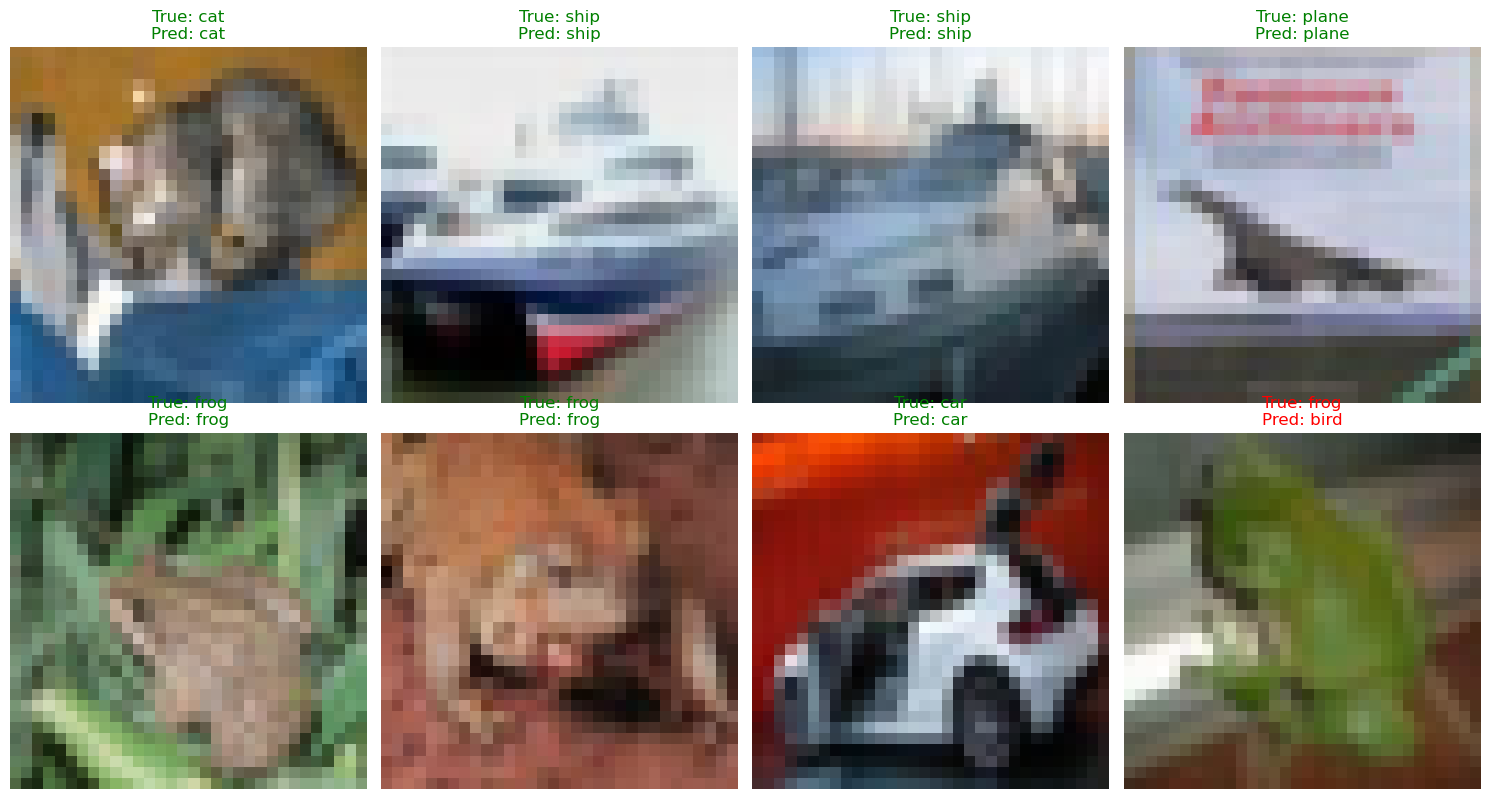

In [12]:
# Evaluate model
print("\nEvaluating model...")
test_accuracy = evaluate_model(model, testloader)

# Show sample predictions
show_sample_predictions(model, testloader)

In [19]:
clean_latents_dict = dict()
device = 'mps'
with torch.no_grad():
    for inputs, targets in testloader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs, clean_latents = model(inputs, return_routed_act=True)
        clean_layents = clean_latents.cpu()
        for latent, target in zip(clean_latents, targets):
            clean_latents_dict[int(target)] =  clean_latents_dict.get(int(target), []) + [latent]
        print(len(clean_latents_dict[0]))

13
26
44
57
68
76
92
108
122
134
142
150
160
179
190
198
216
229
244
254
270
281
289
305
319
330
344
358
369
378
387
397
416
429
446
457
464
478
488
500
515
534
545
557
567
580
591
607
619
636
650
668
680
695
709
724
734
741
755
764
782
802
817
824
831
841
853
860
872
886
905
917
926
934
953
966
980
998
1000


In [21]:
clean_latents_dict.keys()

dict_keys([3, 8, 0, 6, 1, 9, 5, 7, 4, 2])

In [22]:
len(clean_latents_dict[0][0])

128

In [23]:
clean_latents_dict[0][0].shape

torch.Size([128, 8, 8])

In [24]:
torch.mean(clean_latents_dict[0][0][64:])

tensor(0.0602, device='mps:0')

In [25]:
torch.mean(clean_latents_dict[0][0][:64])

tensor(0.1713, device='mps:0')

In [18]:
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# CIFAR-10 class names for better labeling
cifar10_classes = {
    0: 'airplane',
    1: 'automobile', 
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}

def visualize_latent_pca(clean_latents_dict):
    """
    Perform 2D PCA on latent representations and create visualization
    
    Args:
        clean_latents_dict: Dictionary where keys are class labels (0-9) 
                           and values are lists of latent tensors
    """
    
    # Prepare data for PCA
    all_latents = []
    all_labels = []
    
    for class_label, latent_list in clean_latents_dict.items():
        for latent_tensor in latent_list:
            # Convert tensor to numpy and flatten if needed
            if isinstance(latent_tensor, torch.Tensor):
                latent_np = latent_tensor.detach().cpu().numpy()
            else:
                latent_np = latent_tensor
            
            # Flatten the latent vector (keeping batch dimension if present)
            if latent_np.ndim > 1:
                latent_flat = latent_np.reshape(latent_np.shape[0], -1)
                all_latents.extend(latent_flat)
                all_labels.extend([class_label] * latent_flat.shape[0])
            else:
                all_latents.append(latent_np.flatten())
                all_labels.append(class_label)
    
    # Convert to numpy arrays
    X = np.array(all_latents)
    y = np.array(all_labels)
    
    print(f"Data shape for PCA: {X.shape}")
    print(f"Number of samples per class:")
    unique, counts = np.unique(y, return_counts=True)
    for class_id, count in zip(unique, counts):
        print(f"  Class {class_id} ({cifar10_classes[class_id]}): {count} samples")
    
    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X)
    
    print(f"\nPCA Results:")
    print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
    print(f"Total explained variance: {pca.explained_variance_ratio_.sum():.3f}")
    
    # Create the visualization
    plt.figure(figsize=(12, 8))
    
    # Use a colormap with distinct colors
    colors = plt.cm.tab10(np.linspace(0, 1, 10))
    
    # Plot each class with different colors
    for class_id in range(10):
        mask = y == class_id
        if np.any(mask):
            plt.scatter(X_pca[mask, 0], X_pca[mask, 1], 
                       c=[colors[class_id]], 
                       label=f'{class_id}: {cifar10_classes[class_id]}',
                       alpha=0.6, s=20)
    
    plt.xlabel(f'First Principal Component (explains {pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'Second Principal Component (explains {pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('2D PCA of CIFAR-10 Latent Representations')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    return pca, X_pca, y

# Example usage with your data:
pca_model, pca_data, labels = visualize_latent_pca(clean_latents_dict)
plt.show()

NameError: name 'clean_latents_dict' is not defined

In [213]:
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def analyze_latent_halves(clean_latents_dict):
    """Analyze similarity within first and second halves of latent tensors for each class"""
    
    cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
                       'dog', 'frog', 'horse', 'ship', 'truck']
    
    for class_id, latent_list in clean_latents_dict.items():
        print(f"\nClass {class_id} ({cifar10_classes[class_id]}):")
        
        # Extract first and second halves
        first_halves = []
        second_halves = []
        
        for tensor in latent_list:
            # print(tensor.shape)
            if isinstance(tensor, torch.Tensor):
                tensor = tensor.detach().cpu().numpy()
            
            # Split along the correct dimension BEFORE flattening
            first_half = tensor[:64] 
            second_half = tensor[64:] 
            # print(second_half.shape)
            
            # Now flatten each half
            first_flat = first_half.reshape(first_half.shape[0], -1) if first_half.ndim > 1 else first_half.reshape(1, -1)
            second_flat = second_half.reshape(second_half.shape[0], -1) if second_half.ndim > 1 else second_half.reshape(1, -1)
            
            for f, s in zip(first_flat, second_flat):
                first_halves.append(f)
                second_halves.append(s)
        
        first_halves = np.array(first_halves)
        second_halves = np.array(second_halves)
        
        # Calculate cosine similarities
        first_sim = cosine_similarity(first_halves)
        second_sim = cosine_similarity(second_halves)
        
        # Get upper triangle (exclude diagonal)
        mask = np.triu(np.ones_like(first_sim, dtype=bool), k=1)
        first_similarities = first_sim[mask]
        second_similarities = second_sim[mask]
        
        print(f"  First half  - Mean: {first_similarities.mean():.3f}, Std: {first_similarities.std():.3f}")
        print(f"  Second half - Mean: {second_similarities.mean():.3f}, Std: {second_similarities.std():.3f}")
        print(f"  Samples: {len(first_halves)}")

# Usage:
analyze_latent_halves(clean_latents_dict)


Class 3 (cat):
  First half  - Mean: 0.036, Std: 0.123
  Second half - Mean: 0.001, Std: 0.020
  Samples: 960

Class 8 (ship):
  First half  - Mean: 0.032, Std: 0.114
  Second half - Mean: 0.001, Std: 0.020
  Samples: 1088

Class 0 (airplane):
  First half  - Mean: 0.033, Std: 0.117
  Second half - Mean: 0.001, Std: 0.018
  Samples: 832

Class 6 (frog):
  First half  - Mean: 0.037, Std: 0.130
  Second half - Mean: 0.001, Std: 0.019
  Samples: 1216

Class 1 (automobile):
  First half  - Mean: 0.032, Std: 0.111
  Second half - Mean: 0.001, Std: 0.018
  Samples: 640

Class 9 (truck):
  First half  - Mean: 0.034, Std: 0.114
  Second half - Mean: 0.001, Std: 0.019
  Samples: 704

Class 5 (dog):
  First half  - Mean: 0.034, Std: 0.122
  Second half - Mean: 0.001, Std: 0.019
  Samples: 576

Class 7 (horse):
  First half  - Mean: 0.036, Std: 0.122
  Second half - Mean: 0.001, Std: 0.020
  Samples: 832

Class 4 (deer):
  First half  - Mean: 0.033, Std: 0.121
  Second half - Mean: 0.001, Std: 0

In [27]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_tensor_heatmap(tensor, figsize=(16, 8)):
    """
    Plot heatmap of a 4D tensor with shape [1, channels, height, width]
    First 64 channels in orange, second 64 channels in blue, 0 values are white.
    
    Args:
        tensor: PyTorch tensor of shape [1, 128, 8, 8]
        figsize: Figure size tuple
    """
    # Remove batch dimension and convert to numpy
    data = tensor.squeeze(0).detach().cpu().numpy()  # Shape: [128, 8, 8]
    
    # Calculate grid dimensions (8x16 for 128 channels)
    n_channels = data.shape[0]
    cols = 16
    rows = 8
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()
    
    # Fixed range for consistent color scale across all subplots
    vmin, vmax = 0, 2
    
    # Create custom colormaps (white at 0, colored at max)
    from matplotlib.colors import LinearSegmentedColormap
    
    # Orange colormap: white -> dark orange
    orange_cmap = LinearSegmentedColormap.from_list('orange', ['white', '#CC4400'])
    
    # Blue colormap: white -> navy blue  
    blue_cmap = LinearSegmentedColormap.from_list('blue', ['white', 'navy'])
    
    # Plot each channel
    for i in range(n_channels):
        if i < 64:
            # First 64 channels in orange
            cmap = orange_cmap
            title_color = 'darkorange'
        else:
            # Second 64 channels in blue
            cmap = blue_cmap
            title_color = 'darkblue'
            
        im = axes[i].imshow(data[i], cmap=cmap, vmin=vmin, vmax=vmax)
        axes[i].set_title(f'{i}', fontsize=6, color=title_color)
        axes[i].axis('off')
    
    plt.tight_layout(pad=0.5)
    plt.show()

# Example usage:
# tensor = torch.randn(1, 128, 8, 8)  # Your tensor
# plot_tensor_heatmap(tensor)


In [19]:
def show_adv_examples(adv_images):
    # Show first 4 examples (or less if batch is smaller)
    num_to_show = min(4, adv_images.shape[0])
    
    fig, axes = plt.subplots(1, num_to_show, figsize=(12, 3))
    if num_to_show == 1:
        axes = [axes]
    
    for i in range(num_to_show):
        # Convert from (C, H, W) to (H, W, C) and move to CPU
        img = adv_images[i].permute(1, 2, 0).cpu().detach()
        
        # Clip values to [0, 1] range for display
        img = torch.clamp(img, 0, 1)
        
        axes[i].imshow(img)
        axes[i].set_title(f'Adv Example {i+1}')
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

In [26]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_1d_tensor_heatmap(tensor, figsize=(20, 6)):
    """
    Plot heatmap of a 2D tensor with shape [1, 4096]
    First 128 values in orange, remaining values in blue, 0 values are white.
    
    Args:
        tensor: PyTorch tensor of shape [1, 4096]
        figsize: Figure size tuple
    """
    # Remove batch dimension and convert to numpy
    data = tensor.squeeze(0).detach().cpu().numpy()  # Shape: [4096]
    
    # Reshape into a 2D grid for visualization (64x64 = 4096)
    grid_size = int(np.sqrt(len(data)))
    data_2d = data.reshape(grid_size, grid_size)
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize)
    
    # Fixed range for consistent color scale
    vmin, vmax = 0, data.max()
    
    # Create custom colormaps
    from matplotlib.colors import LinearSegmentedColormap
    orange_cmap = LinearSegmentedColormap.from_list('orange', ['white', '#CC4400'])
    blue_cmap = LinearSegmentedColormap.from_list('blue', ['white', 'navy'])
    
    # Create masks for orange and blue regions
    orange_mask = np.zeros_like(data_2d)
    blue_mask = np.zeros_like(data_2d)
    
    # First 128 values (first 2 rows) are orange
    orange_indices = np.unravel_index(np.arange(128), data_2d.shape)
    blue_indices = np.unravel_index(np.arange(128, 4096), data_2d.shape)
    
    orange_mask[orange_indices] = 1
    blue_mask[blue_indices] = 1
    
    # Plot orange section
    orange_data = np.where(orange_mask, data_2d, np.nan)
    im1 = ax1.imshow(orange_data, cmap=orange_cmap, vmin=vmin, vmax=vmax)
    ax1.set_title('First 128 values (Orange)', color='#CC4400', fontsize=12)
    ax1.axis('off')
    
    # Plot blue section
    blue_data = np.where(blue_mask, data_2d, np.nan)
    im2 = ax2.imshow(blue_data, cmap=blue_cmap, vmin=vmin, vmax=vmax)
    ax2.set_title('Remaining 3968 values (Blue)', color='navy', fontsize=12)
    ax2.axis('off')
    
    # Add colorbar
    plt.tight_layout()
    # cbar = plt.colorbar(im1, ax=[ax1, ax2], shrink=0.8, aspect=30)
    # cbar.set_label('Value')
    
    plt.show()



python(28742) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(28743) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


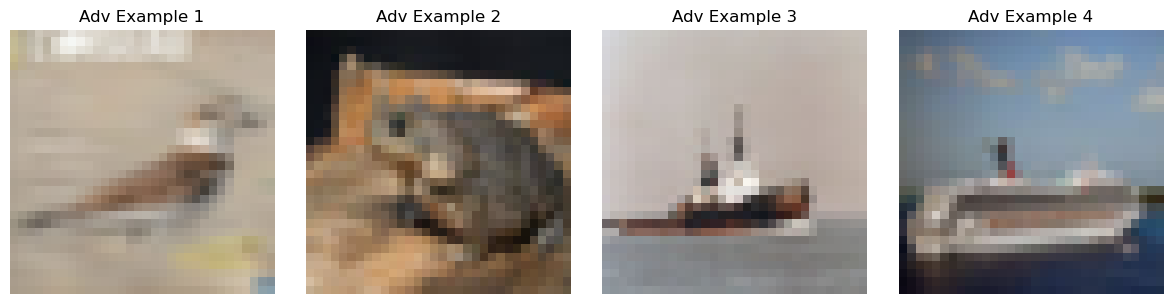

tensor([0, 0, 0, 0, 0], device='mps:0')
Attack success rate: 100.00%
5


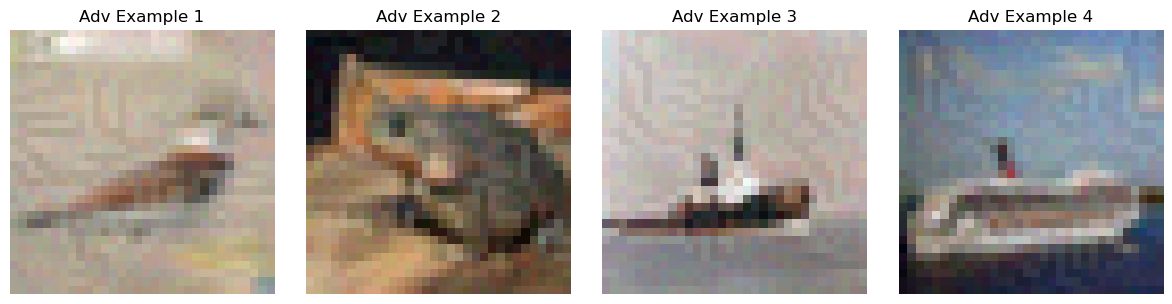

In [20]:
# Simple setup - no complex preprocessing nonsense
model = model.to('mps')
model.eval()
device = 'mps'

# Create attacks
fgsm = torchattacks.FGSM(model, eps=50/255)
fgsm.set_mode_targeted_by_label(quiet=True)
pgd = torchattacks.PGD(model, eps=8/255, alpha=2/255, steps=40)
pgd.set_mode_targeted_by_label(quiet=True)
cw = torchattacks.CW(model, c=1, kappa=0, steps=50)
cw.set_mode_targeted_by_label(quiet=True)
autoattack = torchattacks.AutoAttack(model, eps=8/255)


adv_images = []
imgs = []

# Use your normal data loader (with whatever preprocessing your model expects)
for images, labels in testloader:
    # print(images.shape); break
    images, labels = images.to(device)[70:75], labels.to(device)[70:75]
    show_adv_examples(images)
    
    # Generate adversarial examples
    target_labels = torch.zeros_like(labels)
    adv_images = pgd(images, target_labels)
    imgs = images.clone()
    
    # Evaluate
    with torch.no_grad():
        outputs = model(adv_images.to(device))
        # print(outputs.device)
        _, predicted = torch.max(outputs, 1)
        print(predicted)
        # print(predicted.device)
        
    success_rate = (predicted == target_labels).float().mean()
    print(f'Attack success rate: {success_rate:.2%}')
    print(len(labels))
    break

show_adv_examples(adv_images)

tensor(0, device='mps:0') tensor(5, device='mps:0')


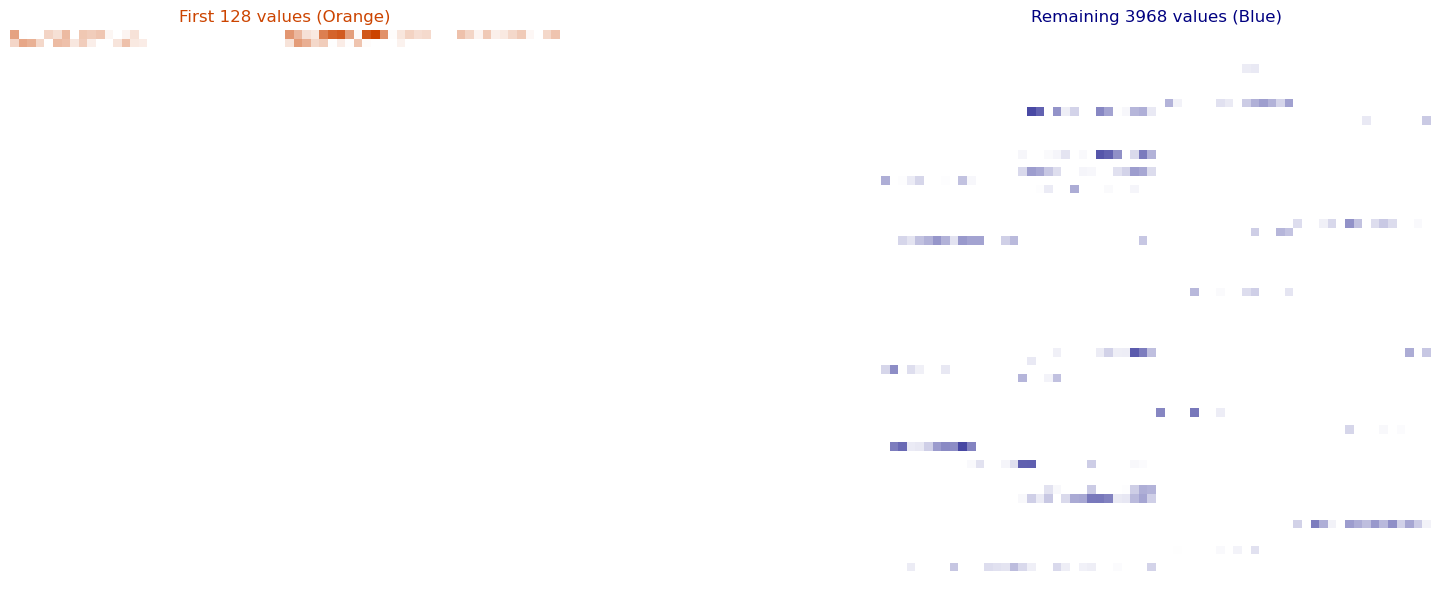

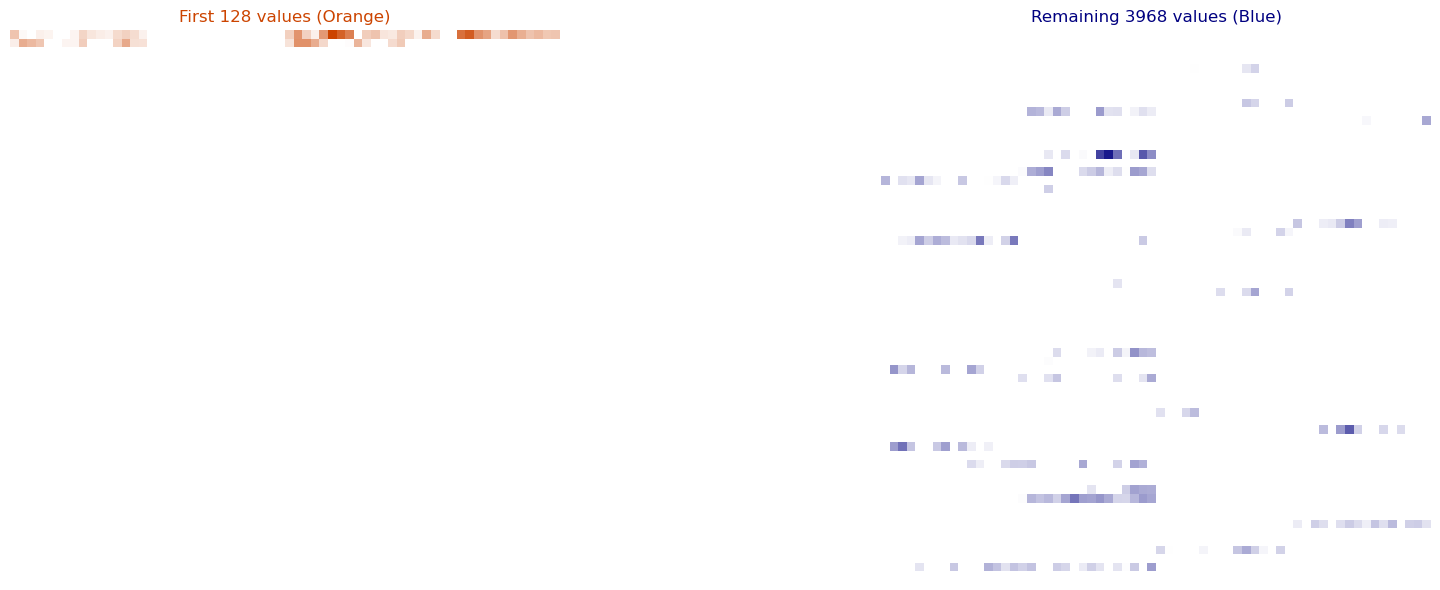

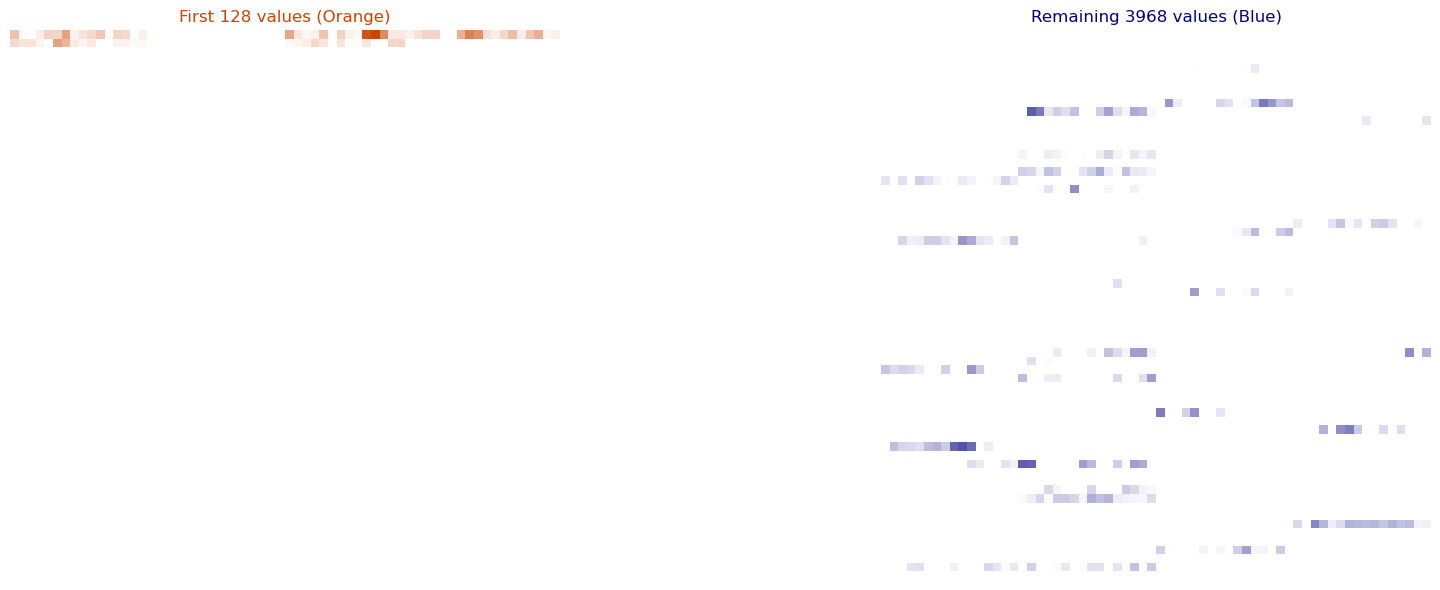

In [27]:
i = 1
outs_adv, latent_tensor_adv = model(adv_images[i:i+1], return_routed_act=True)
outs_clean, latent_tensor_clean = model(imgs[i:i+1], return_routed_act=True)
print(torch.argmax(outs_adv), torch.argmax(outs_clean))
plot_1d_tensor_heatmap(latent_tensor_adv)
plot_1d_tensor_heatmap(latent_tensor_clean)
plot_1d_tensor_heatmap(torch.abs(latent_tensor_clean - latent_tensor_adv))

tensor(0, device='mps:0') tensor(8, device='mps:0')


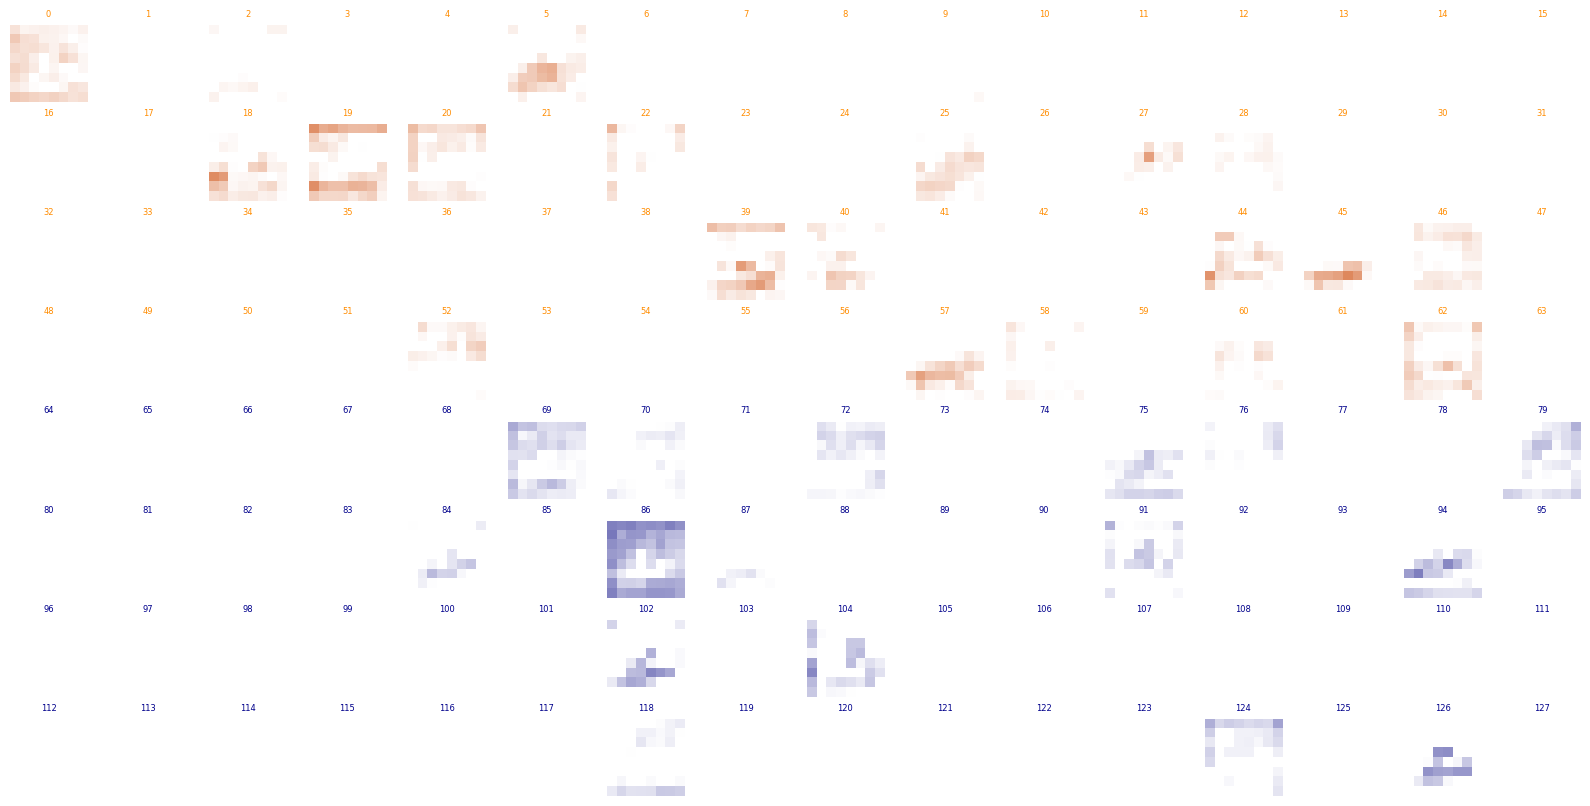

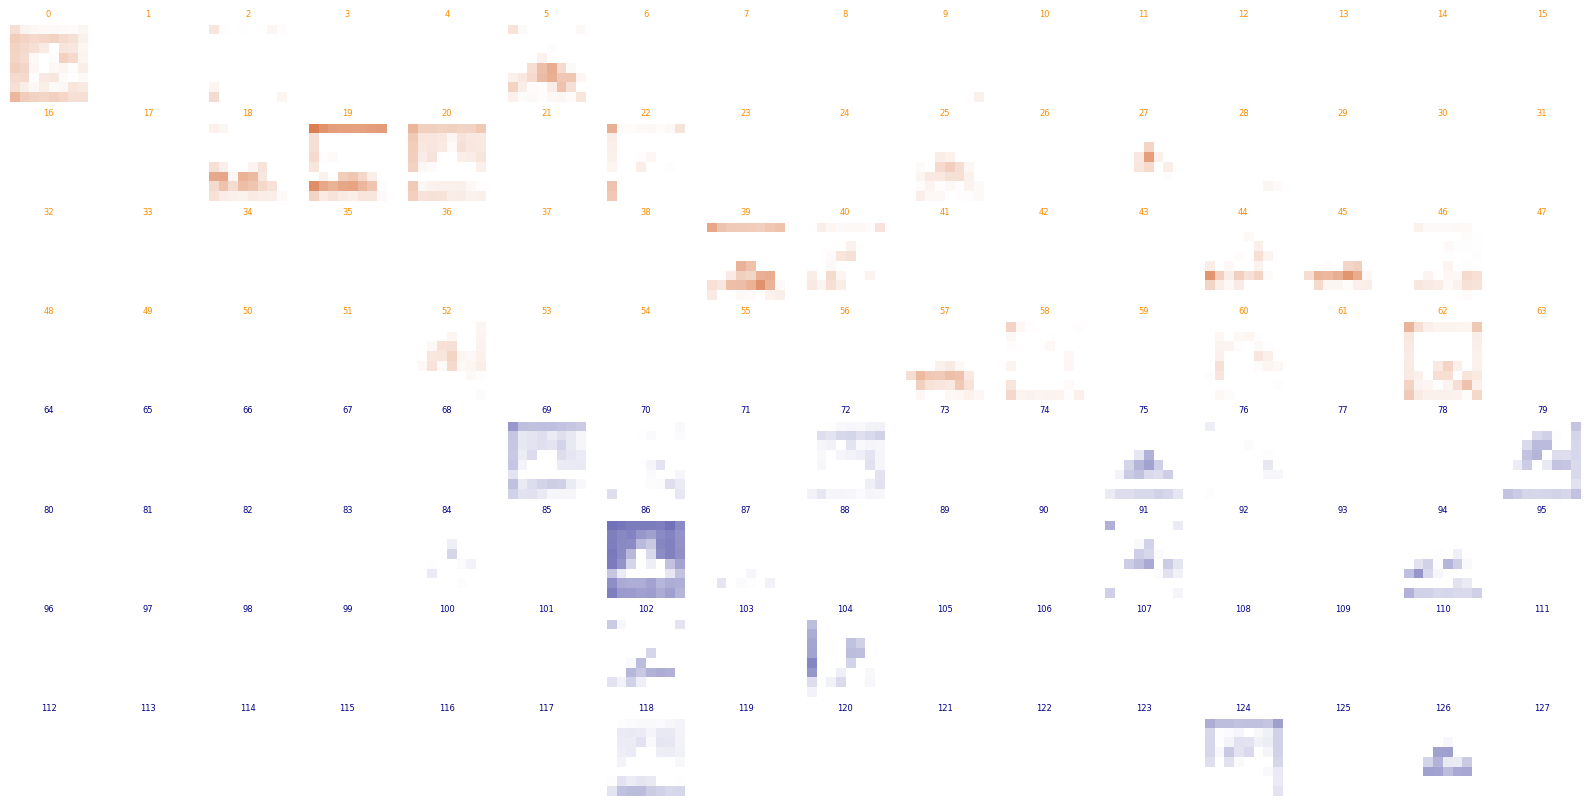

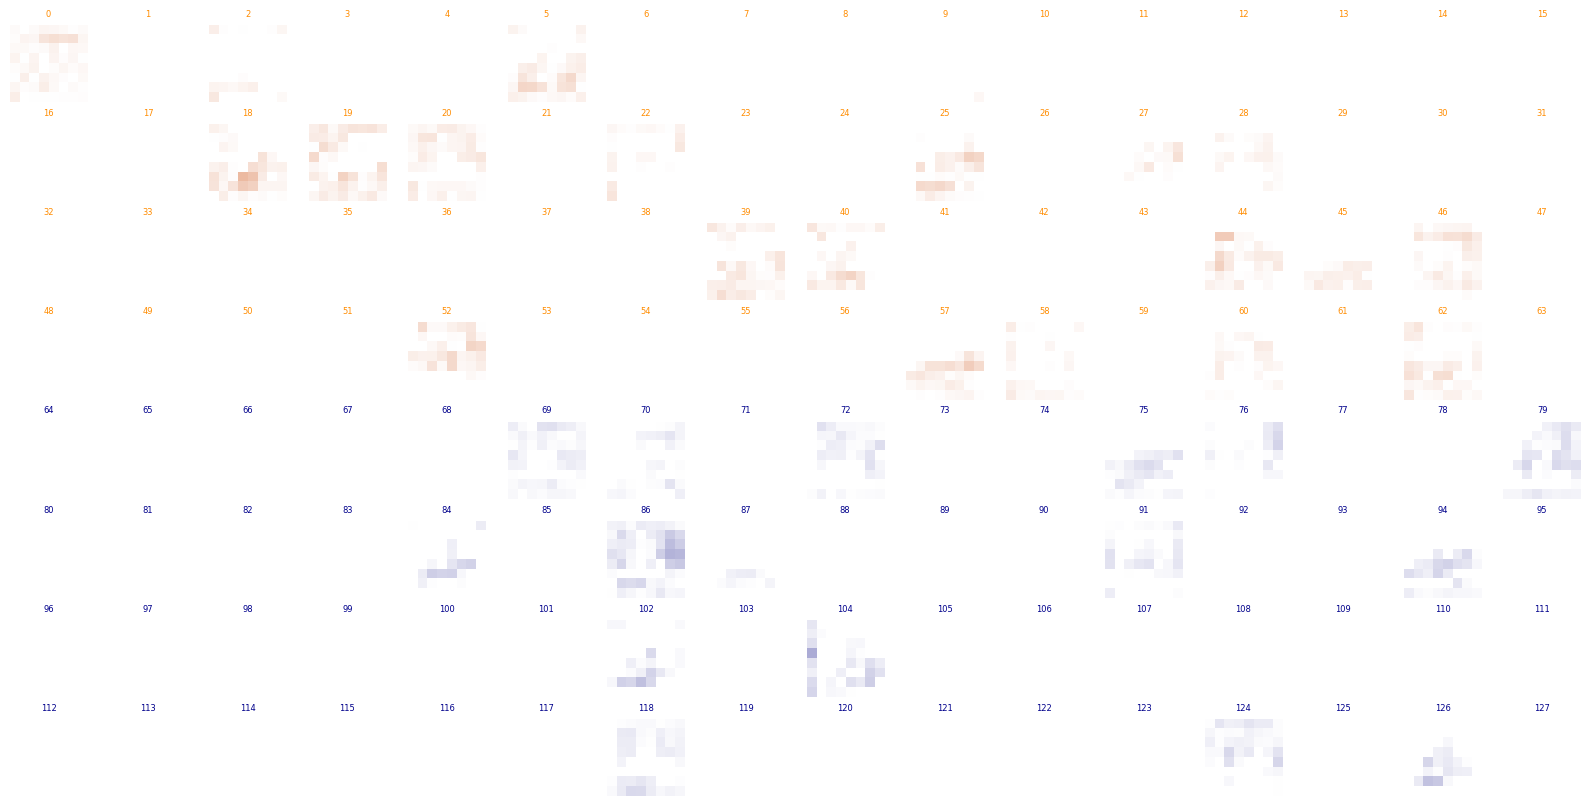

In [28]:
i = 2
outs_adv, latent_tensor_adv = model(adv_images[i:i+1], return_routed_act=True)
outs_clean, latent_tensor_clean = model(imgs[i:i+1], return_routed_act=True)
print(torch.argmax(outs_adv), torch.argmax(outs_clean))
plot_tensor_heatmap(latent_tensor_adv)
plot_tensor_heatmap(latent_tensor_clean)
plot_tensor_heatmap(torch.abs(latent_tensor_clean - latent_tensor_adv))

tensor(0, device='mps:0') tensor(8, device='mps:0')


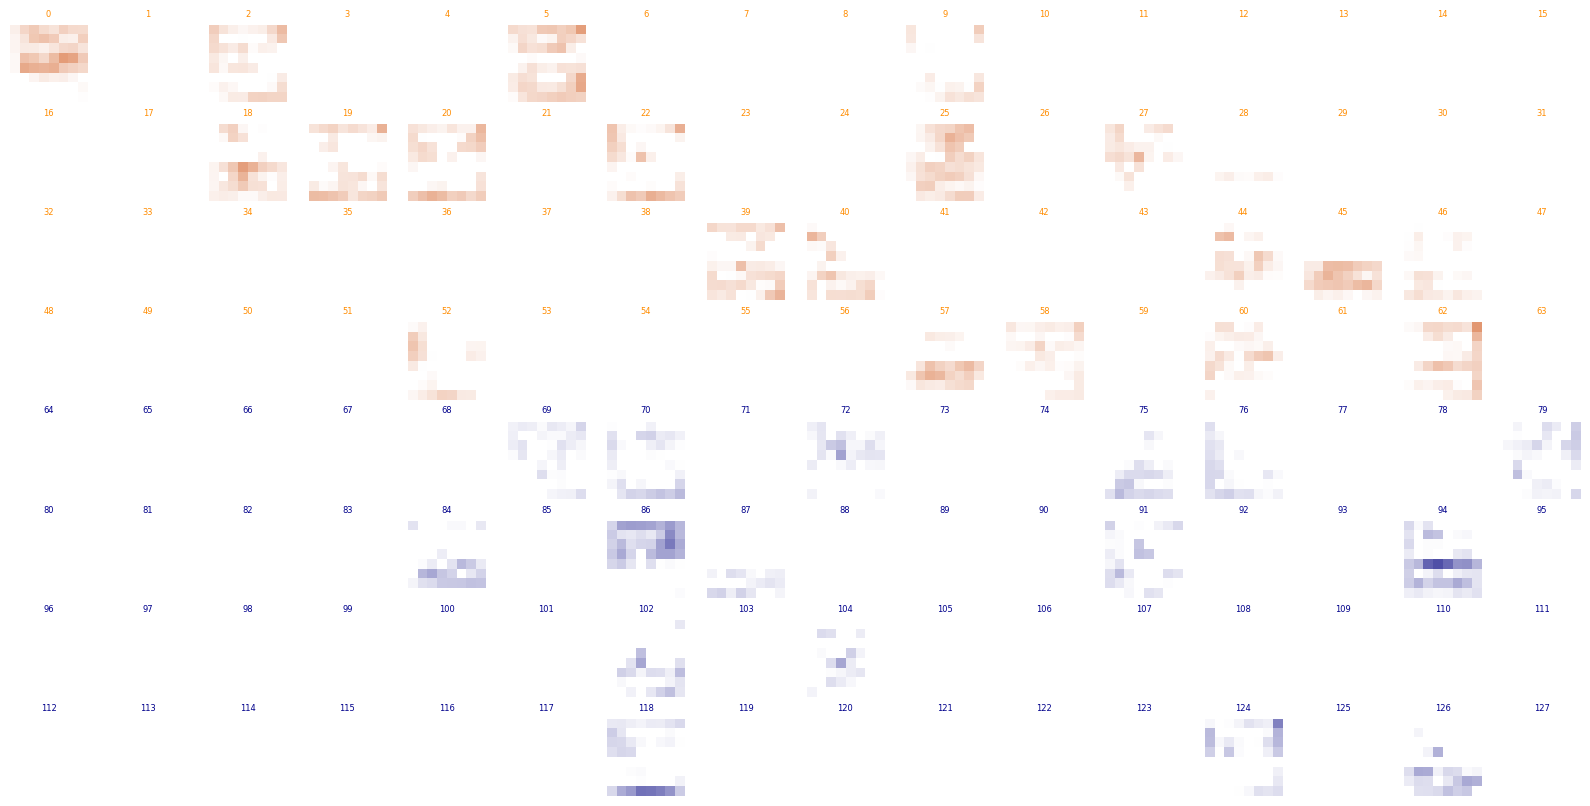

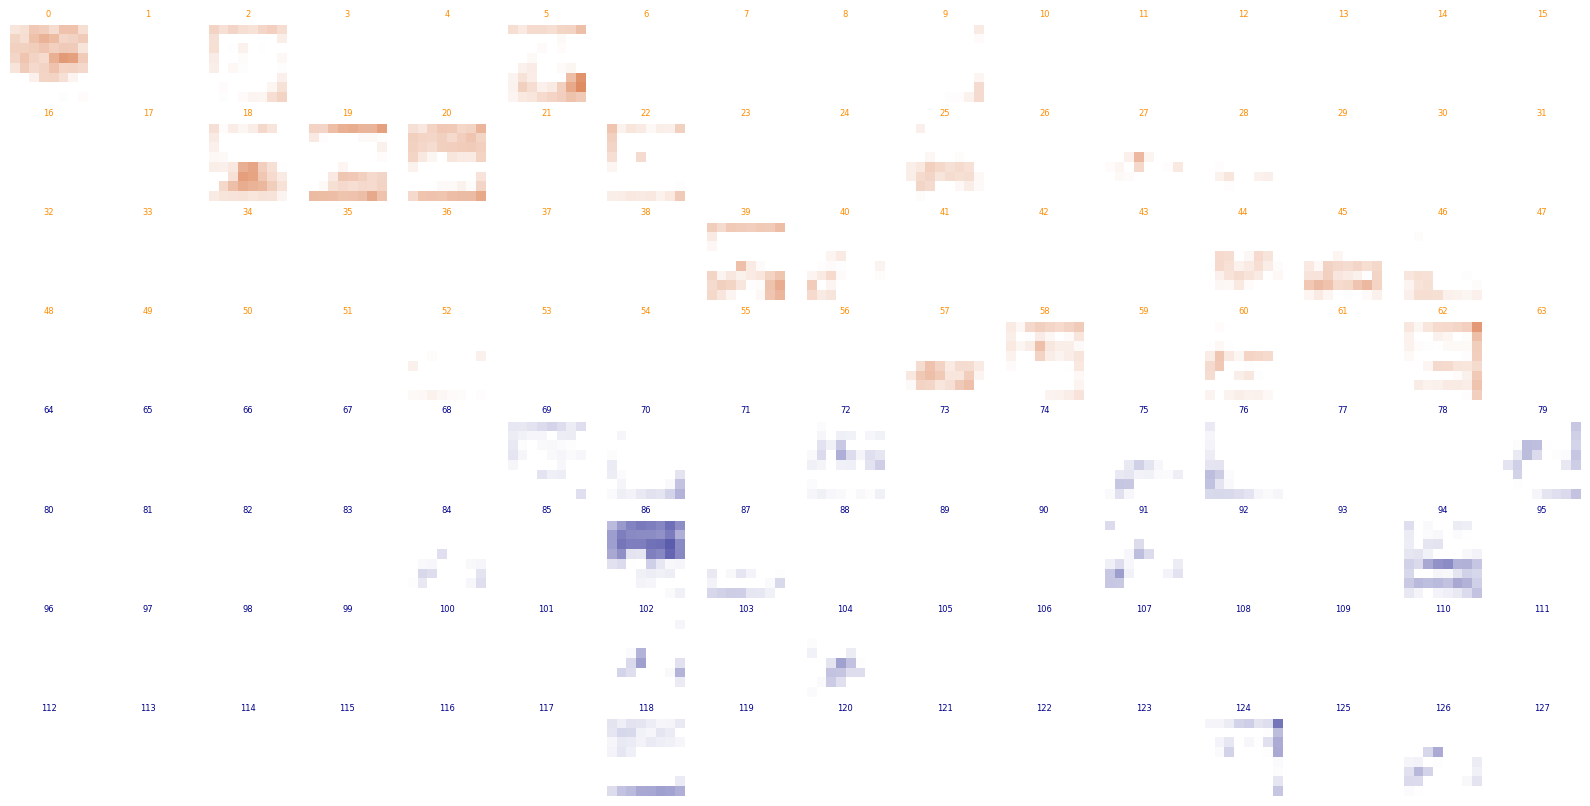

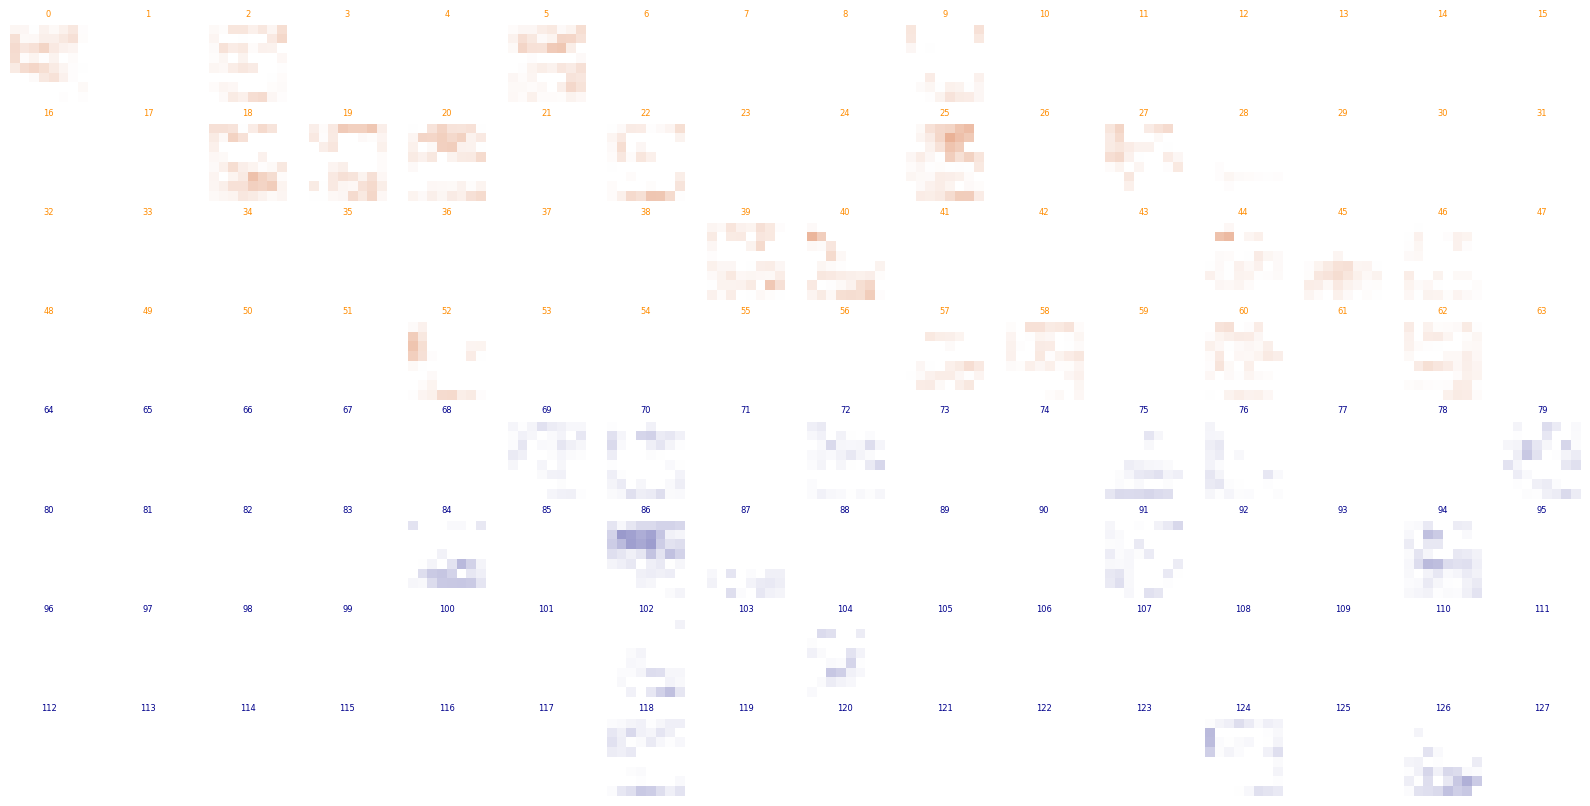

In [29]:
i = 3
outs_adv, latent_tensor_adv = model(adv_images[i:i+1], return_routed_act=True)
outs_clean, latent_tensor_clean = model(imgs[i:i+1], return_routed_act=True)
print(torch.argmax(outs_adv), torch.argmax(outs_clean))
plot_tensor_heatmap(latent_tensor_adv)
plot_tensor_heatmap(latent_tensor_clean)
plot_tensor_heatmap(torch.abs(latent_tensor_clean - latent_tensor_adv))

tensor(0, device='mps:0') tensor(3, device='mps:0')


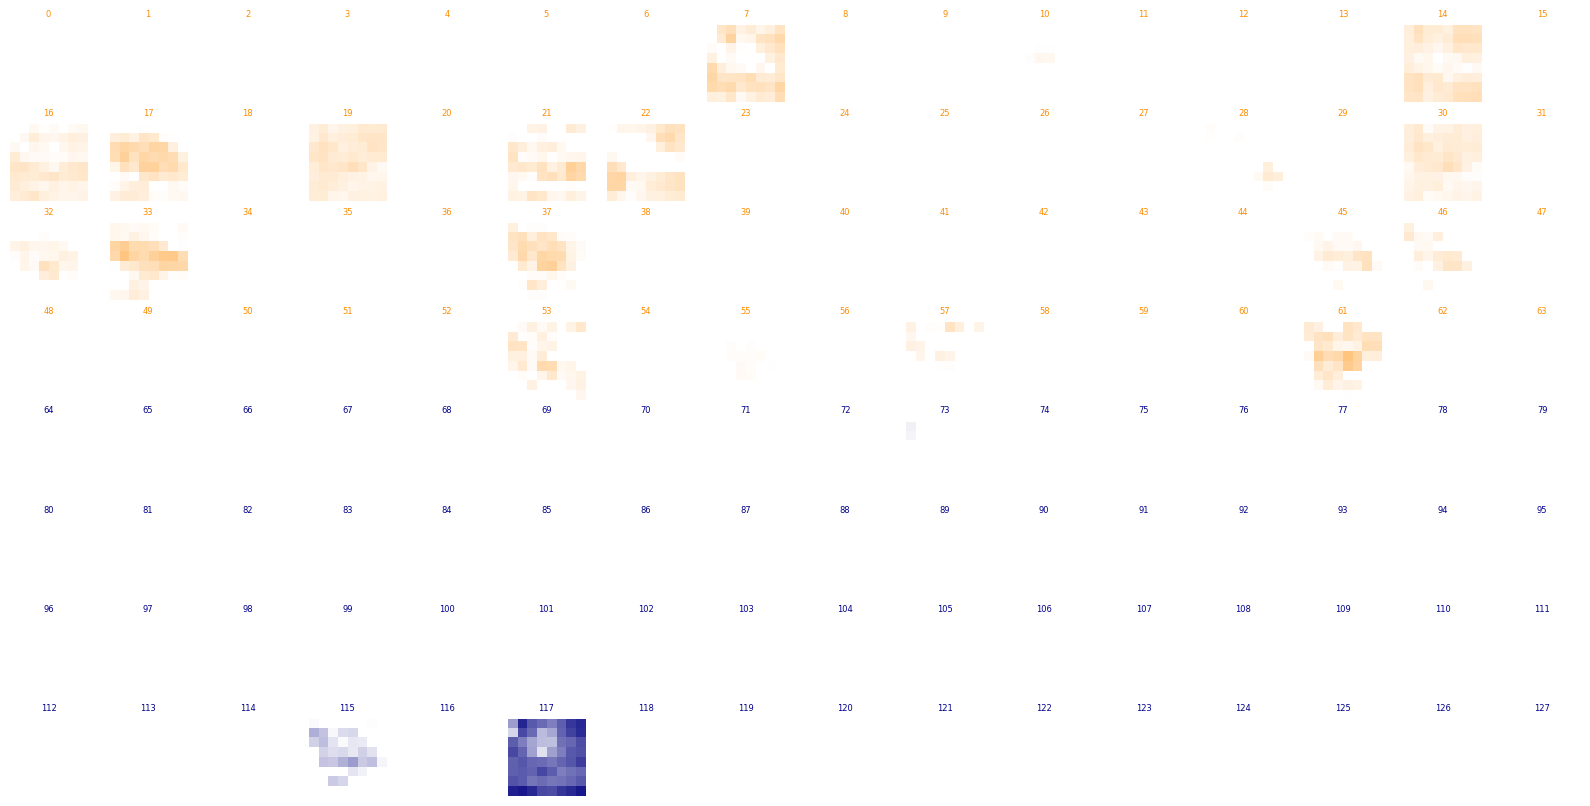

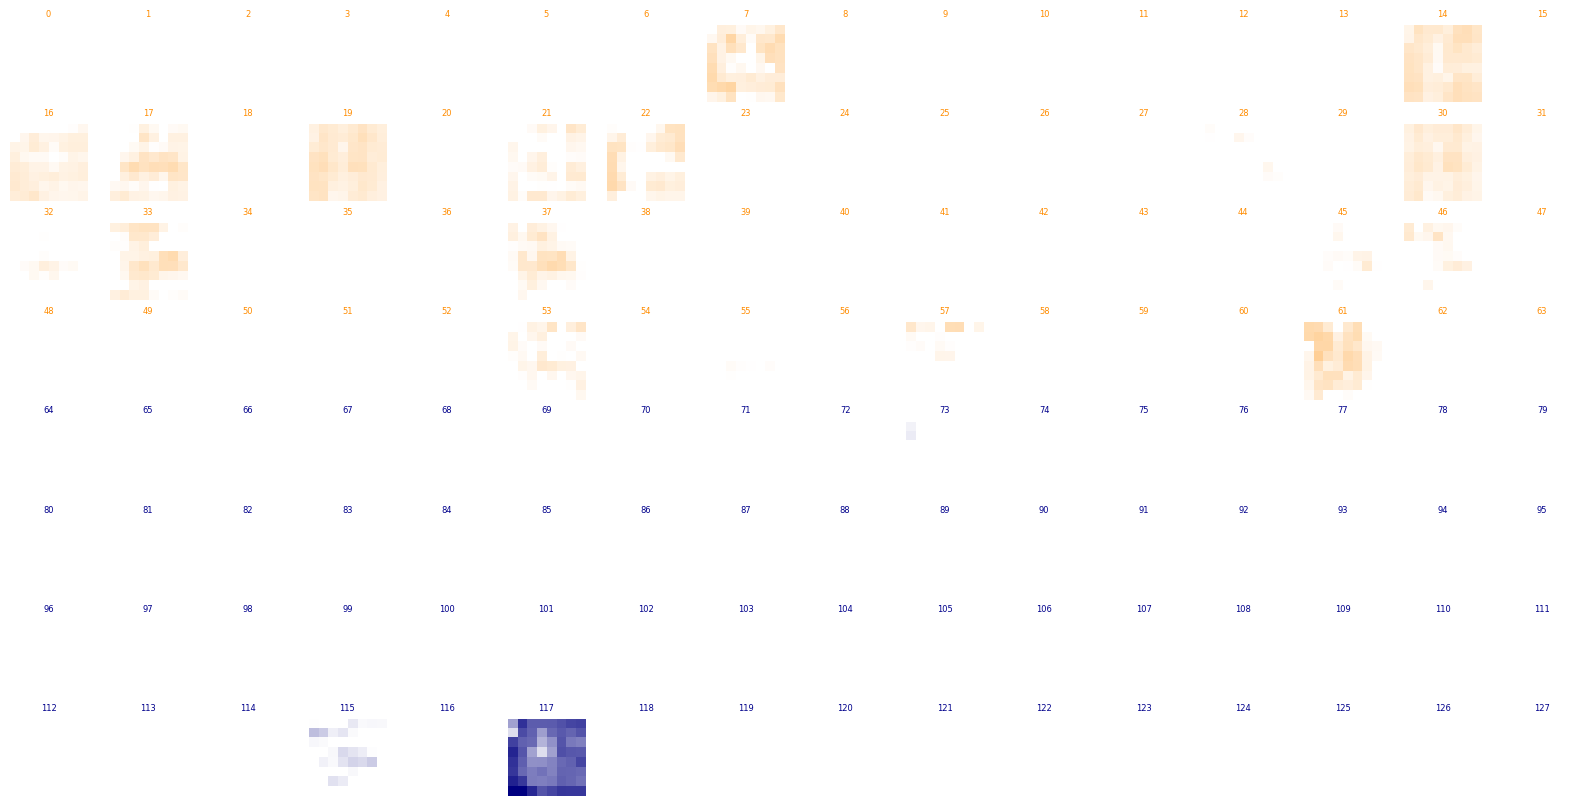

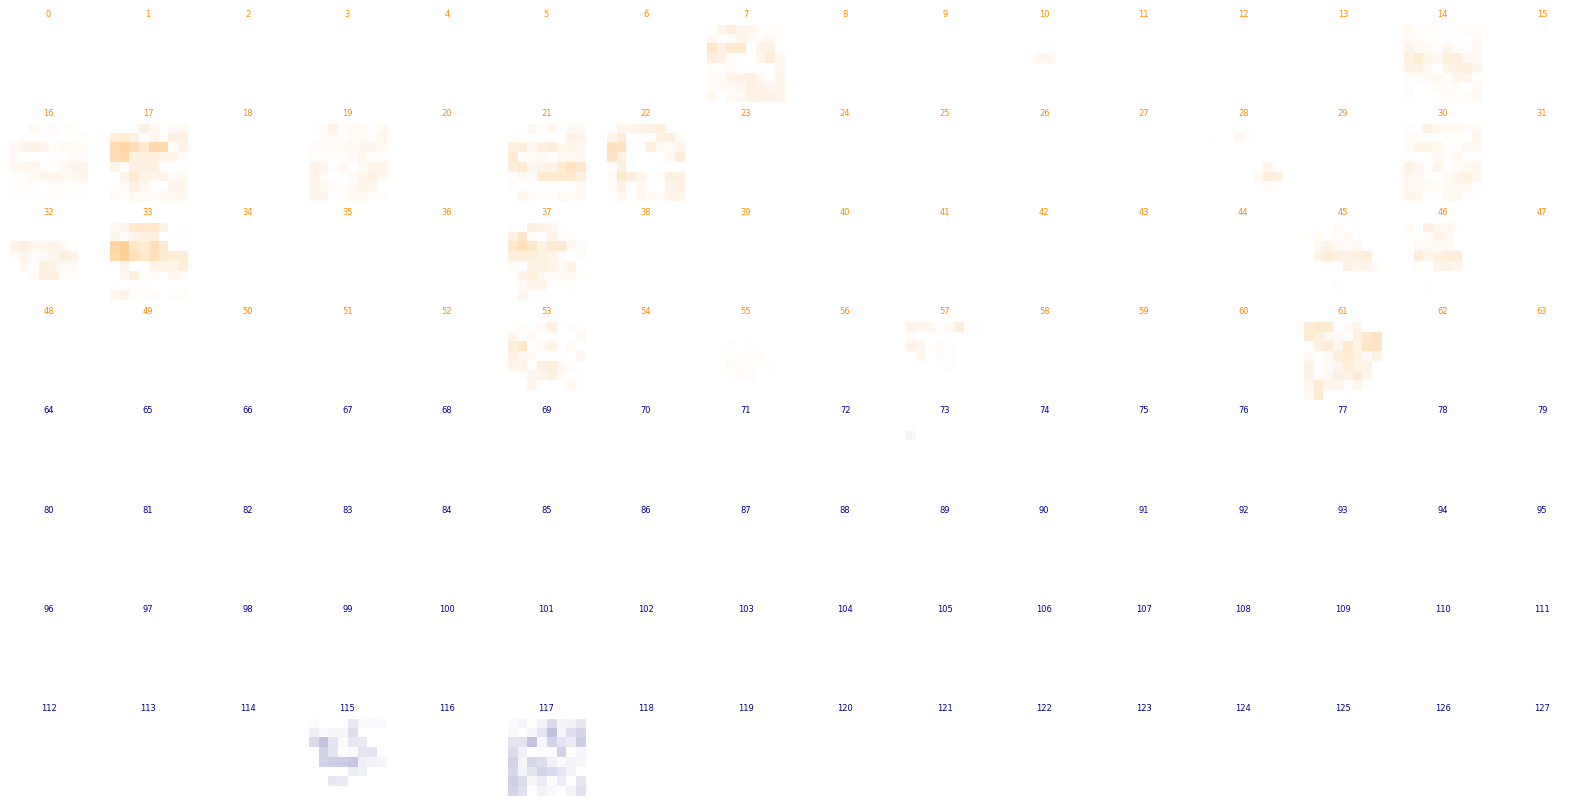

In [128]:
i = 3
outs_adv, latent_tensor_adv = model(adv_images[i:i+1], return_routed_act=True)
outs_clean, latent_tensor_clean = model(imgs[i:i+1], return_routed_act=True)
print(torch.argmax(outs_adv), torch.argmax(outs_clean))
plot_tensor_heatmap(latent_tensor_adv)
plot_tensor_heatmap(latent_tensor_clean)
plot_tensor_heatmap(torch.abs(latent_tensor_clean - latent_tensor_adv))

In [117]:
torch.argmax(outs_adv), torch.argmax(outs_clean)

(tensor(0, device='mps:0'), tensor(8, device='mps:0'))